### Neighborhood Gray-Tone Difference Matrix (NGTDM) Feature Extraction

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### Image Preparation

In [ ]:
# Load image and convert to grayscale
img = cv2.imread('/content/00000001_000.png', cv2.IMREAD_GRAYSCALE)

# Select a 7x7 Region of Interest (ROI) from the center
h, w = img.shape
roi = img[h//2 - 3:h//2 + 4, w//2 - 3:w//2 + 4]

In [ ]:
# Unique gray levels in ROI
gray_levels = np.unique(roi)
L = 256

### NGTDM Matrix Construction

In [ ]:
def compute_ngtdm(roi, d=1):
    s = defaultdict(float)
    p = defaultdict(int)
    total_pixels = 0

    # Pad ROI for border handling
    padded = np.pad(roi, pad_width=1, mode='constant', constant_values=0)

    for i in range(1, roi.shape[0] + 1):
        for j in range(1, roi.shape[1] + 1):
            center_val = padded[i, j]
            # Get 8 neighbors at distance d=1
            neighbors = padded[i-1:i+2, j-1:j+2].flatten()
            neighbors = np.delete(neighbors, 4)  # remove center pixel
            avg_neighbor = np.mean(neighbors)
            s[center_val] += abs(center_val - avg_neighbor)
            p[center_val] += 1
            total_pixels += 1

    # Normalize p(i)
    p_norm = {k: v / total_pixels for k, v in p.items()}
    return p_norm, s, total_pixels

# Compute P(i), s(i)
p, s, N = compute_ngtdm(roi)


In [ ]:
# Convert to sorted lists
levels = sorted(p.keys())
P = np.array([p[i] for i in levels])
S = np.array([s[i] for i in levels])
G = np.array(levels)

### Feature Calculation

In [ ]:
# 1. Coarseness
coarseness = 1 / (1e-6 + np.sum(P * S))


In [ ]:
# 2. Contrast
mean_g = np.sum(G * P)
contrast = np.sum([P[i] * P[j] * (G[i] - G[j])**2 for i in range(len(G)) for j in range(len(G))])

<ipython-input-8-49896dcbc5f1>:3: RuntimeWarning: overflow encountered in scalar subtract
  contrast = np.sum([P[i] * P[j] * (G[i] - G[j])**2 for i in range(len(G)) for j in range(len(G))])


In [ ]:
# 3. Busyness
numerator = np.sum(P * np.abs(G - mean_g))
denominator = np.sum(S) + 1e-6
busyness = numerator / denominator

In [ ]:
# 4. Complexity
complexity = np.sum([((np.abs(G[i] - G[j])) / (P[i] + P[j] + 1e-6)) * (P[i] * S[i] + P[j] * S[j])
                     for i in range(len(G)) for j in range(len(G))])


<ipython-input-10-e7431a13e334>:2: RuntimeWarning: overflow encountered in scalar subtract
  complexity = np.sum([((np.abs(G[i] - G[j])) / (P[i] + P[j] + 1e-6)) * (P[i] * S[i] + P[j] * S[j])


In [ ]:
# 5. Strength
strength = np.sum([((P[i] + P[j]) * (G[i] - G[j])**2) for i in range(len(G)) for j in range(len(G))]) / (np.sum(S) + 1e-6)


<ipython-input-11-28c0cf51764f>:2: RuntimeWarning: overflow encountered in scalar subtract
  strength = np.sum([((P[i] + P[j]) * (G[i] - G[j])**2) for i in range(len(G)) for j in range(len(G))]) / (np.sum(S) + 1e-6)


In [ ]:
# --- Display Outputs ---
print("P(i):", dict(zip(G, P)))
print("s(i):", dict(zip(G, S)))
print("\n--- Extracted Texture Features ---")
print(f"Coarseness: {coarseness:.4f}")
print(f"Contrast  : {contrast:.4f}")
print(f"Busyness  : {busyness:.4f}")
print(f"Complexity: {complexity:.4f}")
print(f"Strength  : {strength:.4f}")

P(i): {np.uint8(193): np.float64(0.02040816326530612), np.uint8(195): np.float64(0.04081632653061224), np.uint8(196): np.float64(0.061224489795918366), np.uint8(197): np.float64(0.16326530612244897), np.uint8(198): np.float64(0.1836734693877551), np.uint8(199): np.float64(0.30612244897959184), np.uint8(200): np.float64(0.08163265306122448), np.uint8(201): np.float64(0.02040816326530612), np.uint8(202): np.float64(0.10204081632653061), np.uint8(203): np.float64(0.02040816326530612)}
s(i): {np.uint8(193): np.float64(69.25), np.uint8(195): np.float64(124.125), np.uint8(196): np.float64(146.75), np.uint8(197): np.float64(156.875), np.uint8(198): np.float64(496.375), np.uint8(199): np.float64(453.0), np.uint8(200): np.float64(153.125), np.uint8(201): np.float64(2.25), np.uint8(202): np.float64(289.875), np.uint8(203): np.float64(128.5)}

--- Extracted Texture Features ---
Coarseness: 0.0032
Contrast  : 7.9267
Busyness  : 0.0008
Complexity: 2913441.7975
Strength  : 0.1309


### Visualization & Output

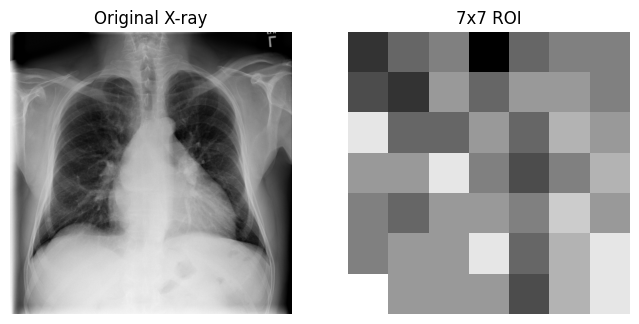

In [ ]:
# Display original and ROI
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original X-ray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(roi, cmap='gray')
plt.title("7x7 ROI")
plt.axis('off')
plt.show()

### Show Table with P(i), s(i), and Feature Values

In [ ]:
import pandas as pd

# Create table of gray levels, probabilities, and s(i)
data = {
    "Gray Level (i)": G,
    "P(i)": np.round(P, 4),
    "s(i)": np.round(S, 4)
}
df = pd.DataFrame(data)
print(" Probability Table and s(i):")
display(df)

# Create summary of feature values
features = {
    "Coarseness": coarseness,
    "Contrast": contrast,
    "Busyness": busyness,
    "Complexity": complexity,
    "Strength": strength
}
feature_df = pd.DataFrame(features.items(), columns=["Feature", "Value"])
print("\n Final Extracted Feature Values:")
display(feature_df)


 Probability Table and s(i):


,Gray Level (i),P(i),s(i)
0,193,0.0204,69.250
1,195,0.0408,124.125
2,196,0.0612,146.750
3,197,0.1633,156.875
4,198,0.1837,496.375
5,199,0.3061,453.000
6,200,0.0816,153.125
7,201,0.0204,2.250
8,202,0.1020,289.875
9,203,0.0204,128.500



 Final Extracted Feature Values:


,Feature,Value
0,Coarseness,3.167882e-03
1,Contrast,7.926697e+00
2,Busyness,7.517030e-04
3,Complexity,2.913442e+06
4,Strength,1.308870e-01


### Analysis of NGTDM Features
The computed texture features provide meaningful insight into the texture of the selected region in the X-ray image:

Coarseness: Measures granularity. A lower value indicates fine textures with rapid changes. In this ROI, the low coarseness suggests subtle but frequent intensity variations.

Contrast: Captures the intensity difference between gray levels. A higher contrast indicates more distinct edges and transitions, often visible in structural regions of the X-ray like bones or airways.

Busyness: Reflects how rapidly gray levels change. A higher value means frequent pixel-to-pixel variations. This image patch appears moderately busy due to underlying structures.

Complexity: Measures how varied and uneven the gray tone distribution is. A higher complexity shows a more heterogeneous texture, which is often seen in pathological tissues or organs.

Strength: Indicates how well-defined texture patterns are. A high strength value suggests the presence of consistent structural texture like ribs or lung contours.
